In [14]:
! pip install jsonlines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
import pandas as pd
import numpy as np
import os
import jsonlines
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm
from nltk.corpus import stopwords
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
f1 = open("/content/drive/MyDrive/GrammarCorrection/entries.train") # OPENING THE FILE 
lines1 = f1.readlines() # READING THE LINES
inp1 = [] # LIST FOR STORING INCORRECT SENTENCES
tgt1 = [] # LIST FOR STORING

for i in lines1: # FOR EACH LINE 
    lst = i.split("\t") # WE ARE SPLITTING THE LINE AT \t
    
# IF LENGTH OF THE LIST IS GREATER THAN 5 THEN CORRECT SENTTENCE EXISTS OTHERWISE ONLY INCORRECT SENTENCE IS PRESENT 
    if len(lst)>5  :     #IF LENGTH IS GREATER THAN 5  
        inp1.append(lst[-2]) # APPEND SECONG LAST ITEM IN LIST WHICH IS INCORRECT SENTENCE
        tgt1.append(lst[-1]) # APPEND LAST ITEM IN THE LIST WHICH IS CORRECT SENTECE.

In [17]:
'''THIS CELL READS THE SMS_TEXT DATASET FILE AND EXTRACTS INCORRECT AND CORRECT SENTENCES ONLY'''


f2 = open("/content/drive/MyDrive/GrammarCorrection/en2cn-2k.en2nen2cn","r",encoding="UTF-8") # READING THE FILE

lines2 = f2.readlines() # STORING ALL THE LINES IN A VARIABLE
inp2 = [] # LIST FOR STORING INCORRECT SENTENCES
tgt2 = [] # LIST FOR STORING CORRECT SENTENCES

# THE DASET CONTAINS 2000 DATAPOINTS, THEREFORE RUNNING THE LOOP FOR 2000 TIMES
for i in range(2000): 
    inp2.append(lines2[i*3]) #APPEDING FIRST ROW FOR EACH DATAPOINT
    tgt2.append(lines2[i*3+1]) # APPENDING SECOND ROW FOR EACH DATAPOINT

#Combining DAtaset

In [18]:
df = pd.DataFrame() # CREATING THE DATAFRAME
df["incorrect"] = inp1+inp2 # ADDING BOTH THE LISTS OF INPUTS TO ONE COLUMN
df["correct"] =  tgt1+tgt2 # ADDING BOTH THE LISTS OF TARGETS TO ONE COLUMN
df["y"] = list("1"*len(inp1)) + list("2"*len(inp2))
df

,incorrect,correct,y
0,And he took in my favorite subject like soccer .,And he took in my favorite subjects like socce...,1
1,"Actually , who let me know about Lang - 8 was ...","Actually , he was the one who let me know abou...",1
2,His Kanji 's ability is much better than me .,His Kanji ability is much better than mine .\n,1
3,"We 've known each other for only half a year ,...","We 've known each other for only half a year ,...",1
4,I heard a sentence last night when I watched TV .,I heard a sentence last night when I was watch...,1
...,...,...,...
511158,Hmmm... Thk i usually book on wkends... Depend...,Hmm. I think I usually book on weekends. It de...,2
511159,ask them got any sms messages to gif me lei......,Can you ask them whether they have for any sms...,2
511160,We r near coca oredi...\n,We are near Coca already.\n,2
511161,hall Eleven. Got lectures le mah.èn forget abt...,Hall eleven. Got lectures. And forget about co...,2


#Data Preprocessing


In [19]:
def remove_spaces(data):
  data = re.sub(r" '(\w)",r"'\1",data)
  data = re.sub(r" \,",",",data)
  data = re.sub(r" \.+",".",data)
  data = re.sub(r" \?+","?",data)
  data = re.sub(r" \!+","!",data)
  data = re.sub(" n't","n't",data)
  data = re.sub("[\(\)\;\_\^\`\/]","",data)
  return data

#https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/
def decontract(data):
  contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not", "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have", "didn't": "did not",
                     "doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will",
                    "he'll've": "he will have","how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am",
                     "I've": "I have", "isn't": "is not","it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not","needn't've": "need not have","o'clock": "of the clock",
                     "oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would","they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would","we'd've": "we would have","we'll": "we will",
                     "we'll've": "we will have","we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have","when've": "when have","where'd": "where did",
                    "where've": "where have","who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not","won't've": "will not have", "would've": "would have",
                     "wouldn't": "would not","wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are","you've": "you have","n\'t":" not","\'re":" are","\'s": " is","\'d":" would",
                     "\'ll": " will","\'t":" not","\'ve": " have","\'m":" am"}
  for k,v in contractions_dict.items():
    if(k in data):
      data = re.sub(k, v, data)
  return data


def preprocess(data):
  data = re.sub("\n","",data)
  data = remove_spaces(data)   # REMOVING UNWANTED SPACES
  data = re.sub(r"\.+",".",data)
  data = re.sub(r"\!+","!",data)
  data = decontract(data)    # DECONTRACTION
  data = re.sub("[^A-Za-z0-9 ]+","",data)
  data = data.lower()
  return data

In [20]:
df.head(2)

,incorrect,correct,y
0,And he took in my favorite subject like soccer .,And he took in my favorite subjects like socce...,1
1,"Actually , who let me know about Lang - 8 was ...","Actually , he was the one who let me know abou...",1


#Exploartory Data Analysis

##Removing null values

In [21]:
df[df.isna().any(axis=1)]

,incorrect,correct,y


In [22]:
df.dropna(axis=0, how='any', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(511163, 3)

##Removing Duplicates

In [23]:
print(df.duplicated(['correct','incorrect']).values.sum())


df.drop_duplicates(['correct','incorrect'], inplace=True, keep='first')
df.reset_index(drop=True, inplace=True)
df.shape


2265


(508898, 3)

OBSERVATION:

> By dropping duplicates and null values we can reduce the number of datapoints from 511163 to 505910




##Preprocess

In [24]:
df['incorrect'] = df['incorrect'].apply(decontract)
df['correct'] = df['correct'].apply(decontract)

In [26]:
df.isna().any()

incorrect    False
correct      False
y            False
dtype: bool

In [27]:
df[(df['incorrect'] == '') | (df['correct'] == '')].shape

(0, 3)

#Univariate Analysys

##Analysys in chars

###Incorrect

In [28]:
char_count = lambda x: len(str(x))
df['incorrect_char_len'] = df['incorrect'].apply(char_count)
df['correct_char_len'] = df['correct'].apply(char_count)

df['incorrect_char_len'].min(), df['incorrect_char_len'].max()

(1, 2534)

In [30]:
df = df[df['incorrect_char_len'] > 1]
df.reset_index(drop=True, inplace=True)
df.shape

(508893, 5)

In [31]:
for p in range(0,101,10):
  p_value = np.percentile(df['incorrect_char_len'].values, p)
  print(f'{p} th percentile value is: {p_value}')

0 th percentile value is: 2.0
10 th percentile value is: 26.0
20 th percentile value is: 34.0
30 th percentile value is: 41.0
40 th percentile value is: 47.0
50 th percentile value is: 55.0
60 th percentile value is: 63.0
70 th percentile value is: 72.0
80 th percentile value is: 85.0
90 th percentile value is: 109.0
100 th percentile value is: 2534.0


In [32]:
for p in range(90,101):
  p_value = np.percentile(df['incorrect_char_len'].values, p)
  print(f'{p} th percentile value is: {p_value}')
     

90 th percentile value is: 109.0
91 th percentile value is: 112.0
92 th percentile value is: 116.0
93 th percentile value is: 121.0
94 th percentile value is: 126.0
95 th percentile value is: 132.0
96 th percentile value is: 140.0
97 th percentile value is: 150.0
98 th percentile value is: 165.0
99 th percentile value is: 191.0
100 th percentile value is: 2534.0


###Correct

In [33]:
df['correct_char_len'].min(), df['correct_char_len'].max()

(2, 2640)

In [34]:
for p in range(0,101,10):
  p_value = np.percentile(df['correct_char_len'].values, p)
  print(f'{p} th percentile value is: {p_value}')

0 th percentile value is: 2.0
10 th percentile value is: 28.0
20 th percentile value is: 37.0
30 th percentile value is: 43.0
40 th percentile value is: 50.0
50 th percentile value is: 57.0
60 th percentile value is: 66.0
70 th percentile value is: 75.0
80 th percentile value is: 89.0
90 th percentile value is: 112.0
100 th percentile value is: 2640.0


In [35]:
for p in range(90,101):
  p_value = np.percentile(df['correct_char_len'].values, p)
  print(f'{p} th percentile value is: {p_value}')
     

90 th percentile value is: 112.0
91 th percentile value is: 116.0
92 th percentile value is: 120.0
93 th percentile value is: 124.0
94 th percentile value is: 130.0
95 th percentile value is: 136.0
96 th percentile value is: 144.0
97 th percentile value is: 154.0
98 th percentile value is: 169.0
99 th percentile value is: 195.0
100 th percentile value is: 2640.0


##Analysis on words

In [37]:
word_count = lambda x: len(str(x).split()) 

df['incorrect_word_len'] = df.iloc[:, 1].apply(word_count)
df['correct_word_len'] = df.iloc[:, 0].apply(word_count)

In [38]:
# df.to_csv('/content/drive/MyDrive/GrammarCorrection/Data/preprocessed_word.csv', index=False)

In [39]:
data = pd.read_csv('/content/drive/MyDrive/GrammarCorrection/Data/preprocessed_word.csv')

###Histogram for incorrect words

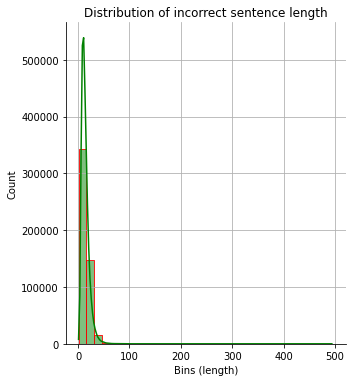

In [40]:
hist_bins = list(range(data['incorrect_word_len'].min(), data['incorrect_word_len'].max()+15,15))
sns.displot(list(data['incorrect_word_len'].values), bins=hist_bins, kde=True, color='green',edgecolor='red')
plt.grid()
plt.title('Distribution of incorrect sentence length')
plt.xlabel("Bins (length)")
plt.show()

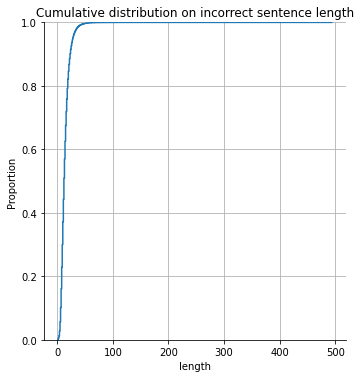

In [41]:
sns.displot(data['incorrect_word_len'].values, kind='ecdf')
plt.xlabel("length")
plt.title("Cumulative distribution on incorrect sentence length")
plt.grid()
plt.show()
     

In [43]:

print("Length statistics of incorrect sentences:")
print("="*100)

print("Minimum : ", data['incorrect_word_len'].min())
print("Maximum : ", data['incorrect_word_len'].max())
print("Mean : ", data['incorrect_word_len'].mean())
print("Median : ", data['incorrect_word_len'].median())
     

Length statistics of incorrect sentences:
Minimum :  1
Maximum :  494
Mean :  13.998355253461925
Median :  12.0


###Histogram for correct words

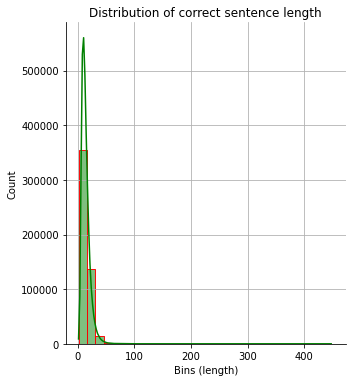

In [44]:
hist_bins = list(range(data['correct_word_len'].min(), data['correct_word_len'].max()+15,15))
sns.displot(list(data['correct_word_len'].values), bins=hist_bins, kde=True, color='green',edgecolor='red')
plt.grid()
plt.title('Distribution of correct sentence length')
plt.xlabel("Bins (length)")
plt.show()

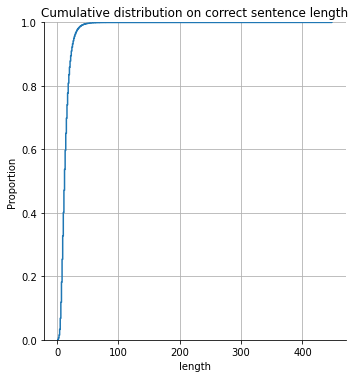

In [45]:
sns.displot(data['correct_word_len'].values, kind='ecdf')
plt.xlabel("length")
plt.title("Cumulative distribution on correct sentence length")
plt.grid()
plt.show()

In [46]:

print("Length statistics of correct sentences:")
print("="*100)

print("Minimum : ", data['correct_word_len'].min())
print("Maximum : ", data['correct_word_len'].max())
print("Mean : ", data['correct_word_len'].mean())
print("Median : ", data['correct_word_len'].median())

Length statistics of correct sentences:
Minimum :  1
Maximum :  448
Mean :  13.56059525283311
Median :  12.0


#Bivariate Analysys

[]

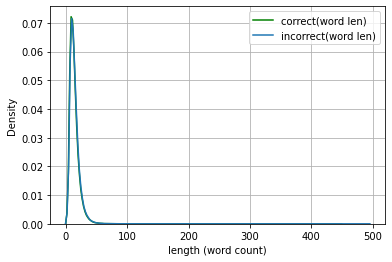

In [47]:
sns.kdeplot(data['correct_word_len'], label='correct(word len)', color='green')
sns.kdeplot(data['incorrect_word_len'], label='incorrect(word len)')
plt.grid()
plt.legend()
plt.xlabel("length (word count)")
plt.plot()

[]

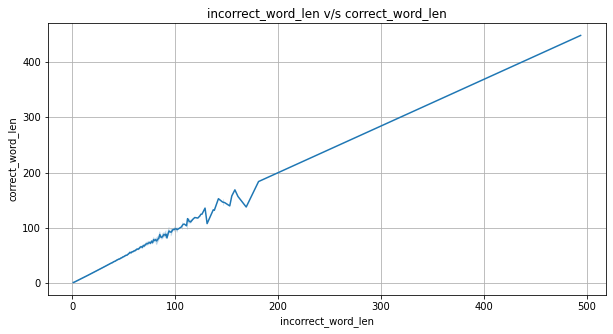

In [48]:
plt.figure(figsize=(10,5))
sns.lineplot(data=data, x='incorrect_word_len', y='correct_word_len')
plt.grid()
plt.title("incorrect_word_len v/s correct_word_len")
plt.plot()
     

#Vocabulary

In [52]:
cv_incorrect = CountVectorizer()
cv_incorrect.fit(data['incorrect'].astype(str).tolist())

print('Incorrect vocab size = ', len(cv_incorrect.get_feature_names()))

Incorrect vocab size =  85673


In [53]:
cv_correct = CountVectorizer()
cv_correct.fit(data['correct'].astype(str).tolist())
print('Correct vocab size = ', len(cv_correct.get_feature_names()))

Correct vocab size =  66597


In [54]:
incorrect_vocab = set(cv_incorrect.get_feature_names())
correct_vocab = set(cv_correct.get_feature_names())

total_words_cnt = len(incorrect_vocab.union(correct_vocab))
total_incorrect_words_cnt = len(incorrect_vocab.difference(correct_vocab))
cnt_correct_words_from_both = len(incorrect_vocab.intersection(correct_vocab))
total_correct_words_cnt = len(correct_vocab.difference(incorrect_vocab)) + cnt_correct_words_from_both

     

print("Count of words from incorrect sentences vocabulary: ", len(incorrect_vocab))
print("Count of words from correct sentences vocabulary: ", len(correct_vocab))
print("\n")
print("Total words: ", total_words_cnt)
print(f"Total incorrect words: {total_incorrect_words_cnt} percentage: {np.round((total_incorrect_words_cnt/total_words_cnt)*100, 4)}")
print(f"Total correct words: {total_correct_words_cnt} percentage: {np.round((total_correct_words_cnt/total_words_cnt)*100, 4)}")
     

Count of words from incorrect sentences vocabulary:  85673
Count of words from correct sentences vocabulary:  66597


Total words:  96403
Total incorrect words: 29806 percentage: 30.9181
Total correct words: 66597 percentage: 69.0819
